In [2]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import LogFormatter

# Sideband Cooling in Λ systems:

In [11]:
'''
each of eta, Gamma, Delta are arrays of length 2 (noting coupling between each of 0 and 1 states to 2 state)

Below is for computing ss without using the effective operator formalism
'''
def compute_ss(n_motional,nu,Delta,Gamma,eta): 

    # Convention: |g⟩⟨g| and |e⟩⟨e| for ground and excited states
    zero_proj = qt.basis(3, 0).proj()
    one_proj = qt.basis(3, 1).proj()
    ground_proj = zero_proj + one_proj
    
    excited_proj = qt.basis(3, 2).proj()


    D0 = qt.basis(3,0) * qt.basis(3,2).dag()
    D1 = qt.basis(3,1) * qt.basis(3,2).dag()

    # motional state operators
    a = qt.destroy(n_motional)     # Annihilation operator
    a_dag = qt.create(n_motional)  # Creation operator

    # Position operator x 
    x = (a + a_dag) # I ignore units here because we just roll with eta as a parameter rather than worrying about 'k'

    # Identity operators for tensor products
    id_internal = qt.qeye(3)
    id_motional = qt.qeye(n_motional)

    # Define e^(±ikx) operators using the position operator
    def exp_ikx(eta,x):
        exp_x = (1j * eta * x).expm() # I checked that expm works.
        return exp_x

    #Note that we follow a convention - the order is always atomic tensor motional

    '''
    below I introduce the 3LS operators operators
    
    '''
    Gamma0 = Gamma[0]
    Gamma1 = Gamma[1]

    eta0 = eta[0]
    eta1 = eta[1]

    Delta0 = Delta[0]
    Delta1 = Delta[1]
    
    Omega0 = eta0*Gamma0
    Omega1 = eta1*Gamma1

    H_motional = nu * qt.tensor(id_internal, a_dag * a)
    H_atomic = qt.tensor(- Delta0 * qt.fock_dm(3,0) -Delta1* qt.fock_dm(3,1) , id_motional)       #  a |0><0| +  b |1><1|, set energy of |e><e| = 0 
    H_interaction = -(
    Omega0/2* qt.tensor(D0 , exp_ikx(-eta0,x)) + Omega0/2* qt.tensor(D0.dag() , exp_ikx(eta0,x)) +   # |0><e| + c.c
    Omega1/2* qt.tensor(D1 , exp_ikx(-eta1,x)) + Omega1/2* qt.tensor(D1.dag() , exp_ikx(eta1,x))     # |0><e| + c.c
    )   

    H_total = H_motional + H_atomic + H_interaction

    # defining collapse operators
    # collapse operators for emission in positive and negative x-direction (1D)
    L0_plus = np.sqrt(Gamma0) * qt.tensor(D0,  exp_ikx(eta0,x))
    L0_minus = np.sqrt(Gamma0) * qt.tensor(D0, exp_ikx(-eta0,x))
    L1_plus = np.sqrt(Gamma1) * qt.tensor(D1,  exp_ikx(eta1,x))
    L1_minus = np.sqrt(Gamma1) * qt.tensor(D1, exp_ikx(-eta1,x))
    c_ops = [L0_plus, L0_minus, L1_plus, L1_minus]


    '''
    Rather than using MESolver we try using SSSolver (only interested in long-term behavior of system) - as done in the paper. 

    Get steady state values of the system as a function of diff parameters. 
    '''


    rho_ss = qt.steadystate(H_total, c_ops)

    # Measurement operators
    measure_excited = qt.tensor(excited_proj, id_motional)
    measure_ground2 = qt.tensor(one_proj, id_motional)
    measure_ground1 = qt.tensor(zero_proj, id_motional)
    measure_n = qt.tensor(id_internal, a_dag * a)

    # Compute steady-state expectation values
    excited_pop_ss = qt.expect(measure_excited, rho_ss)
    ground2_pop_ss = qt.expect(measure_ground2, rho_ss)
    ground1_pop_ss = qt.expect(measure_ground1, rho_ss)
    motional_n_ss = qt.expect(measure_n, rho_ss)


    return ground1_pop_ss, ground2_pop_ss, excited_pop_ss, motional_n_ss

### Generating the plots for a range of parameters:

In [4]:
# example system parameters based on physical grounds
n_motional = 10         # Number of motional levels
Gamma = np.array([1e6 , 1e6]) # Spontaneous emission rate (Γ) in Hz
Delta = 0.5 * Gamma  # Detuning (Δ) in Hz
nu = 0.5 * Gamma[0]# Trap frequency (ν) in Hz 

eta = np.array([0.05, 0.05])              #Lamb-dicke parameter
# Eta removes the necessity for defining k because already given

ground_pop_ss, excited_pop_ss, motional_n_ss = compute_ss(n_motional,nu,Delta,Gamma,eta)


print("Steady-state excited population:", excited_pop_ss)
print("Steady-state ground population:", ground_pop_ss)
print("Steady-state average phonon number:", motional_n_ss)

# for our upcoming plots, we can take freedom in varying nu, Delta for a given Gamma (of 0.01 MHz)

Steady-state excited population: -1.9791749726919726e-20
Steady-state ground population: 0.9999999999999999
Steady-state average phonon number: 4.064317948904811


### Unresolved Sideband Regime:

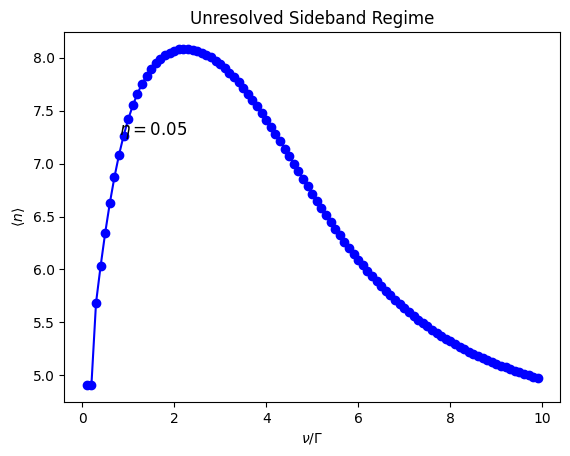

In [5]:
# example system parameters based on physical grounds
n_motional = 15         # Number of motional levels
Gamma = np.array([0.01*1e6 ,0.01* 1e6]) # Spontaneous emission rate (Γ) in Hz
Delta = np.array([2*Gamma[0] ,1.8*Gamma[1]])# red-detuning (Δ) in Hz
eta = np.array([0.05, 0.05])              #Lamb-dicke parameter

nu_values = np.arange(0, 10*Gamma[0], 0.1*Gamma[0])[1:]

avg_n = np.zeros(len(nu_values))

for i, nu in enumerate(nu_values):
    ground1_pop_ss, ground2_pop_ss, excited_pop_ss, motional_n_ss = compute_ss(n_motional,nu,-Delta,Gamma,eta)
    avg_n[i] = motional_n_ss  

# Plotting
fig, ax = plt.subplots()
ax.plot(nu_values / Gamma[0], avg_n, marker='o', linestyle='-', color='b')

# Labels and title
ax.set_xlabel(r'$\nu / \Gamma$')
ax.set_ylabel(r'$\langle n \rangle$')
ax.set_title("Unresolved Sideband Regime")

# Annotation for eta value
ax.text(0.8, max(avg_n) * 0.9, r'$\eta=0.05$', fontsize=12, color='black')

# Show plot
plt.show()

### Some notes:
####    $ \Lambda $ System Hamiltonian:

$$
H =  H_{\text{motional}} + H_{\text{atomic}} + H_{\text{interaction}} 
$$

$$
H_{\text{motional}} = \nu \cdot (\mathbb{I}_{\text{internal}} \otimes a^\dagger a)
$$

$$
H_{\text{atomic}} = (-\Delta_0 |0\rangle\langle 0| - \Delta_1 |1\rangle\langle 1|) \otimes \mathbb{I}_{\text{motional}}
$$

$$
H_{\text{interaction}} = - \left( \frac{\Omega_0}{2} D_0 \otimes e^{-i \eta_0 x} + \frac{\Omega_0}{2} D_0^\dagger \otimes e^{i \eta_0 x} + \frac{\Omega_1}{2} D_1 \otimes e^{-i \eta_1 x} + \frac{\Omega_1}{2} D_1^\dagger \otimes e^{i \eta_1 x} \right)
$$

$$
H_{\text{total}} = H_{\text{motional}} + H_{\text{atomic}} + H_{\text{interaction}}
$$




#### 1. It looks like cooling occurs only for a certain frequency, after which it begins to heat again (i.e., the $\arg\min$ depends on detuning parameters?)  
####    1. cont: argmin seems to depend on difference in deltas. perhaps a 2D plot will give better visual.
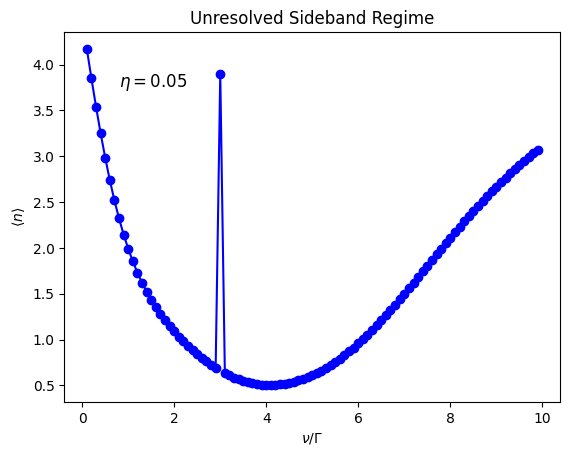
#### 2. $ \Delta $ in the equations exclusively refers to red-detuning, and it was noticed that blue-detuning heats up initially (but I haven't actually tried to scan it over $ \nu $ - I can do it now)  
####    2. cont: I did, and it reaches a maximum and then saturates down at 5 for large $ \nu $ with blue-detuning. Red is hence preferred.  

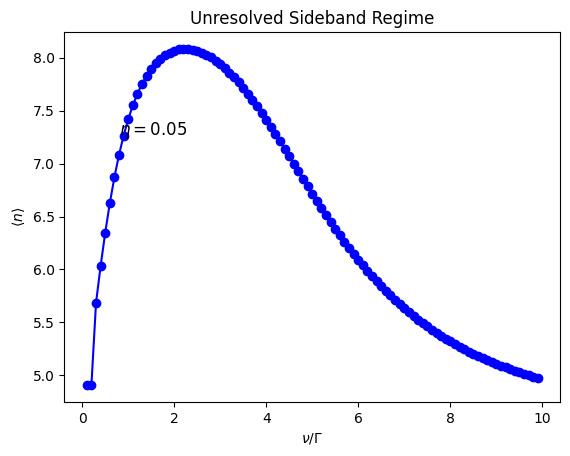


#### 3. I did a 2D param sweep over delta0 (keeping delta1 fixed) and the result is as expected:

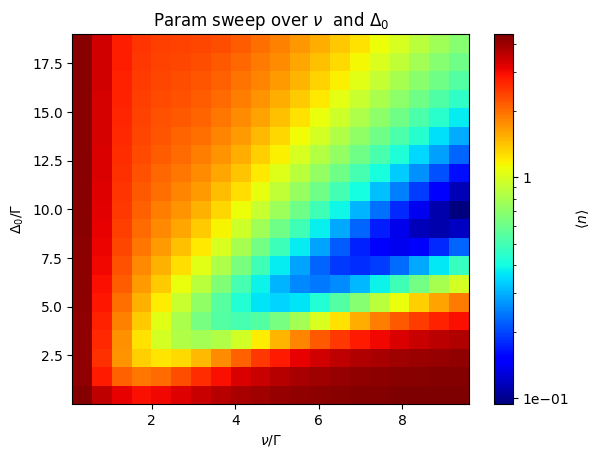

#### We retain the resolved-sideband plot for a 3 level system also. However, it appears that Unresolved sideband regime is not easily obtained for some reason.

#### 4. $ \Delta_0 $ and $ \Delta_1 $ are NOT interchangeable, and the plots match resolved regime but this time as a function of $ \Delta_0 - \Delta_1 $(and NOT the other way around)
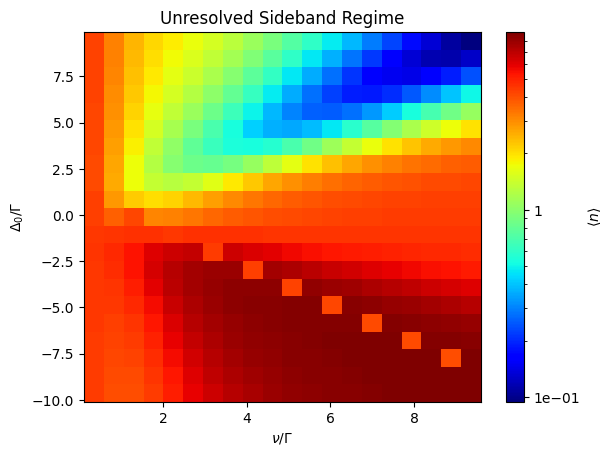

#### Above plot is with $ \Delta_1 $ fixed to $ \Gamma_1$ and $ \Delta_0 $ swept over a bunch of frequencies (negative to positive)

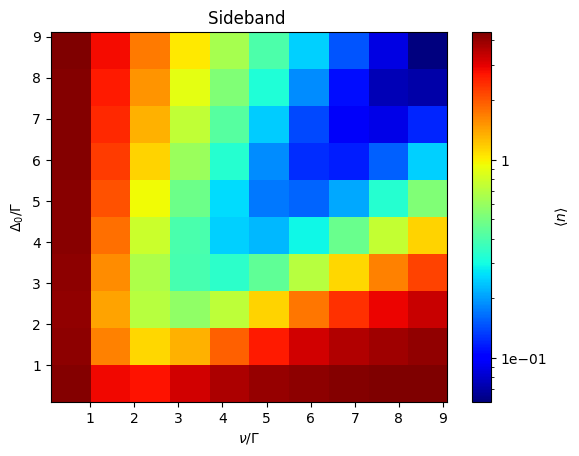

In [28]:
### 2D PLOTTING: PARAM SWEEP OF nu and Delta[0] ###

# Example system parameters based on physical grounds
n_motional = 10         # Number of motional levels
Gamma = np.array([1e6 , 1e6])  # Spontaneous emission rate (Γ) in Hz
eta = np.array([0.05, 0.05])   # Lamb-Dicke parameter

# Parameter ranges
nu_values = np.arange(0.1 * Gamma[0], 10 * Gamma[0], 1 * Gamma[0])  # Frequency values
Delta0_values = np.arange(0.11*Gamma[0], 10 * Gamma[0], 1 * Gamma[0])  # Delta[0] values
# Delta1 = Gamma[1]  # Keeping Delta[1] fixed

delta = Gamma[0]  # qubit frquency detuning

avg_n = np.zeros((len(Delta0_values), len(nu_values)))
e_pop = np.zeros((len(Delta0_values), len(nu_values)))
g2_pop = np.zeros((len(Delta0_values), len(nu_values)))
g1_pop = np.zeros((len(Delta0_values), len(nu_values)))
for i, Delta0 in enumerate(Delta0_values):
    for j, nu in enumerate(nu_values):
        Delta1 = Delta0 + delta
        Delta = np.array([Delta0, Delta1])  # Set Delta[0] and Delta[1]
        ground1_pop_ss, ground2_pop_ss, excited_pop_ss, motional_n_ss = compute_ss(n_motional, nu, Delta, Gamma, eta)
        avg_n[i, j] = motional_n_ss  
        e_pop[i, j] = excited_pop_ss
        g2_pop[i, j] = ground2_pop_ss  
        g1_pop[i, j] = ground1_pop_ss

# Plotting
fig, ax = plt.subplots()
im = ax.imshow(avg_n, 
               extent=[nu_values[0] / Gamma[0], nu_values[-1] / Gamma[0], 
                       Delta0_values[0] / Gamma[0], Delta0_values[-1] / Gamma[0]], 
               origin="lower",
               norm=colors.LogNorm(vmin=np.min(avg_n[avg_n > 0]), vmax=np.max(avg_n)), 
               cmap="jet", aspect = "auto")

# Colorbar
cbar = fig.colorbar(im, ax=ax, format=LogFormatter(10, labelOnlyBase=False))
cbar.set_label(r'$ \langle n \rangle $')

# Labels and title
ax.set_xlabel(r'$\nu / \Gamma$')
ax.set_ylabel(r'$\Delta_0 / \Gamma$')
ax.set_title("Sideband ")

# Annotation
# ax.text(0.8, 0.2, r'$\eta=0.05$', fontsize=12, color='black')

plt.show()


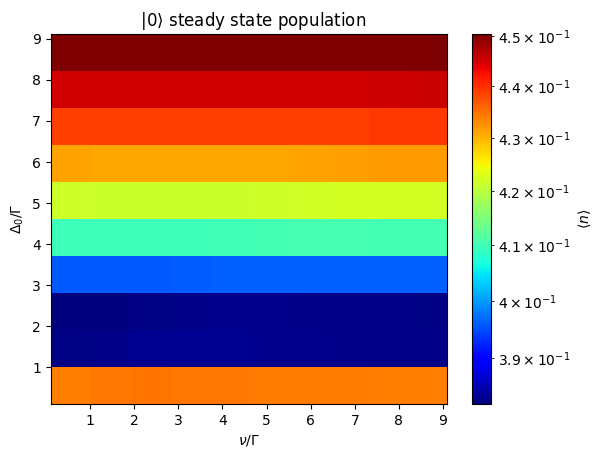

In [29]:
# Plotting
fig, ax = plt.subplots()
im = ax.imshow(g1_pop, 
               extent=[nu_values[0] / Gamma[0], nu_values[-1] / Gamma[0], 
                       Delta0_values[0] / Gamma[0], Delta0_values[-1] / Gamma[0]], 
               origin="lower",
               norm=colors.LogNorm(vmin=np.min(g1_pop[g1_pop > 0]), vmax=np.max(g1_pop)), 
               cmap="jet", aspect = "auto")

# Colorbar
cbar = fig.colorbar(im, ax=ax, format=LogFormatter(10, labelOnlyBase=False))
cbar.set_label(r'$ \langle n \rangle $')

# Labels and title
ax.set_xlabel(r'$\nu / \Gamma$')
ax.set_ylabel(r'$\Delta_0 / \Gamma$')
ax.set_title(r"  $ |0 \rangle$ steady state population ")

# Annotation
# ax.text(0.8, 0.2, r'$\eta=0.05$', fontsize=12, color='black')

plt.show()

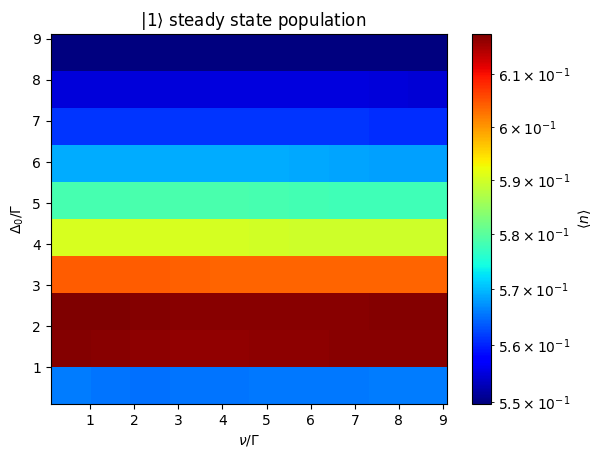

In [30]:
# Plotting
fig, ax = plt.subplots()
im = ax.imshow(g2_pop, 
               extent=[nu_values[0] / Gamma[0], nu_values[-1] / Gamma[0], 
                       Delta0_values[0] / Gamma[0], Delta0_values[-1] / Gamma[0]], 
               origin="lower",
               norm=colors.LogNorm(vmin=np.min(g2_pop[g2_pop > 0]), vmax=np.max(g2_pop)), 
               cmap="jet", aspect = "auto")

# Colorbar
cbar = fig.colorbar(im, ax=ax, format=LogFormatter(10, labelOnlyBase=False))
cbar.set_label(r'$ \langle n \rangle $')

# Labels and title
ax.set_xlabel(r'$\nu / \Gamma$')
ax.set_ylabel(r'$\Delta_0 / \Gamma$')
ax.set_title(r"  $ |1 \rangle$ steady state population ")

# Annotation
# ax.text(0.8, 0.2, r'$\eta=0.05$', fontsize=12, color='black')

plt.show()

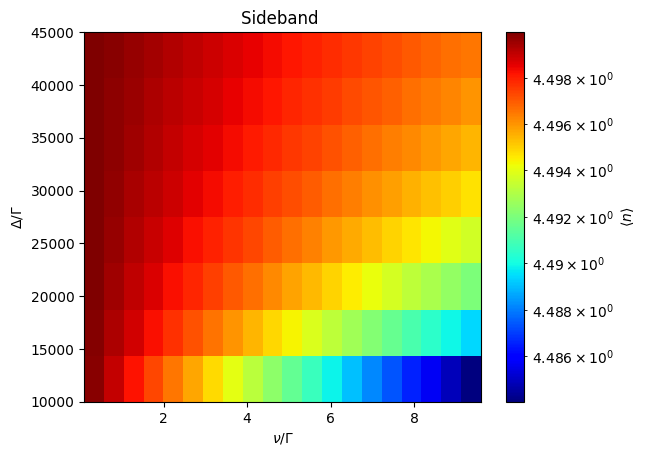

In [46]:
## Large detuning regime : Delta_0,1 >> Gamma, nu

n_motional = 10         # Number of motional levels
Gamma = np.array([1e6 , 1e6])  # Spontaneous emission rate (Γ) in Hz
eta = np.array([0.05, 0.1])   # Lamb-Dicke parameter

# Parameter ranges
nu_values = np.arange(0.1 * Gamma[0], 10 * Gamma[0], 0.5 * Gamma[0])  # Frequency values
Delta_values = np.arange(10000*Gamma[0], 50000 * Gamma[0], 5000 * Gamma[0])  # delta values

qubit_freq = 100 * Gamma[0]  # qubit frquency ~GHz

avg_n = np.zeros((len(Delta_values), len(nu_values)))
e_pop = np.zeros((len(Delta_values), len(nu_values)))
g2_pop = np.zeros((len(Delta_values), len(nu_values)))
g1_pop = np.zeros((len(Delta_values), len(nu_values)))
for i, delta in enumerate(Delta_values):
    for j, nu in enumerate(nu_values):
        Delta = np.array([delta, delta-qubit_freq])  # Set Delta[0] and Delta[1]
        ground1_pop_ss, ground2_pop_ss, excited_pop_ss, motional_n_ss = compute_ss(n_motional, nu, Delta, Gamma, eta)
        avg_n[i, j] = motional_n_ss  
        e_pop[i, j] = excited_pop_ss
        g2_pop[i, j] = ground2_pop_ss  
        g1_pop[i, j] = ground1_pop_ss


# Plotting
fig, ax = plt.subplots()
im = ax.imshow(avg_n, 
               extent=[nu_values[0] / Gamma[0], nu_values[-1] / Gamma[0], 
                       Delta_values[0] / Gamma[0], Delta_values[-1] / Gamma[0]], 
               origin="lower",
               norm=colors.LogNorm(vmin=np.min(avg_n[avg_n > 0]), vmax=np.max(avg_n)), 
               cmap="jet", aspect = "auto")
0 
# Colorbar
cbar = fig.colorbar(im, ax=ax, format=LogFormatter(10, labelOnlyBase=False))
cbar.set_label(r'$ \langle n \rangle $')

# Labels and title
ax.set_xlabel(r'$\nu / \Gamma$')
ax.set_ylabel(r'$\Delta / \Gamma$')
ax.set_title("Sideband ")

# Annotation
# ax.text(0.8, 0.2, r'$\eta=0.05$', fontsize=12, color='black')

plt.show()


In [45]:
avg_n

array([[4.49983417, 4.499005  , 4.49817583, 4.49734667, 4.4965175 ,
        4.49568833, 4.49485917, 4.49403   , 4.49320084, 4.49237167,
        4.49154251, 4.49071334, 4.48988418, 4.48905502, 4.48822585,
        4.48739669, 4.48656753, 4.48573838, 4.48490922, 4.48408006],
       [4.49988963, 4.49933779, 4.49878594, 4.49823409, 4.49768225,
        4.4971304 , 4.49657856, 4.49602671, 4.49547487, 4.49492302,
        4.49437118, 4.49381933, 4.49326749, 4.49271564, 4.4921638 ,
        4.49161195, 4.49106011, 4.49050826, 4.48995642, 4.48940458],
       [4.49991729, 4.49950376, 4.49909022, 4.49867668, 4.49826315,
        4.49784961, 4.49743607, 4.49702254, 4.496609  , 4.49619546,
        4.49578193, 4.49536839, 4.49495486, 4.49454132, 4.49412778,
        4.49371425, 4.49330071, 4.49288718, 4.49247364, 4.4920601 ],
       [4.49993387, 4.4996032 , 4.49927254, 4.49894188, 4.49861122,
        4.49828055, 4.49794989, 4.49761923, 4.49728857, 4.4969579 ,
        4.49662724, 4.49629658, 4.49596592, 4

## $\Lambda$ system but with effective operator formalism: